In [1]:

import warnings
warnings.filterwarnings("ignore")

from appaloosa import RunLC
import os, glob
import pandas as pd


def import_flares(cluster, test, oid):
    
    objectid = str(oid)
    loc = 'stars_shortlist/{}/results/{}'.format(cluster,test)
    flux = pd.read_csv('{}/{}_flux.csv'.format(loc,oid))#, names= ['time','flux_gap','error','flux_model'])
    flares = pd.read_csv('{}/{}_flares.csv'.format(loc,oid))#, names= ['istart','istop'])
    return flux, flares

def RunLC_cluster(oid,run,C='05',cluster='M67',LCtype='everest'):
    folder = 'stars_shortlist'
    loc = '{}/{}/results/{}/results/'.format(folder,cluster,run)
    tpf_loc = '{}/{}/ktwo{}-c{}_lpd-targ.fits.gz'.format(folder,cluster,oid,C)

    if LCtype == 'everest':
        lc_loc = '{}/{}/hlsp_everest_k2_llc_{}-c{}_kepler_v2.0_lc.fits'.format(folder,cluster,oid,C)
        mode = 3
    elif LCtype == 'k2sc':
        mode = 1
        lc_loc = fetch(oid,C,LCtype,cluster)

    fakes = RunLC(lc_loc, dbmode=LCtype, display=True, debug=False, 
                  dofake=True, writeout=False, respath=loc,
                  nfake=20, iterations=3, mode=mode)
    return fakes

def fetch(ID,C,dbmode,cluster):
    if dbmode=='k2sc':
        myfile = 'stars_shortlist/{}/hlsp_k2sc_k2_llc_{}-c{}_kepler_v2_lc.fits'.format(cluster,ID,C)
        file = 'hlsp_k2sc_k2_llc_{}-c{}_kepler_v2_lc.fits'.format(ID,C)
        if glob.glob(myfile)==[]:
            print('Fetching .fits file...')
            os.system('wget -q http://archive.stsci.edu/hlsps/k2sc/v2/c{2}/{0}00000/hlsp_k2sc_k2_llc_{1}-c{2}_kepler_v2_lc.fits'.format(str(ID)[:4],ID,C))
            #myfile_new = 'stars_shortlist/{}/{}'.format(cluster,myfile)
            os.rename(file, myfile)
            
    elif dbmode=='everest':
        myfile = 'hlsp_everest_k2_llc_{}-c{}_kepler_v2.0_lc.fits'.format(ID,C)
        #analogous to k2sc
    return myfile

In [2]:
#k2sc run 6
clusters = {'M44':{'C':'05','test':'run_06','LCtype':'k2sc'},
            'M67':{'C':'05','test':'run_06','LCtype':'k2sc'},
            'Pleiades':{'C':'04','test':'run_06','LCtype':'k2sc'}}

In [3]:
cluster = 'Pleiades'

C = clusters[cluster]['C']
test = clusters[cluster]['test']
LCtype = clusters[cluster]['LCtype']
ploc = 'stars_shortlist/{0}/results/{1}/catalog/{0}_parameter.csv'.format(cluster,test)
params = pd.read_csv(ploc)
params = params[params.todrop == False]
oid_list = params.EPIC.astype(int).tolist()
print(len(oid_list))


714



This is the 0th light curve in the current pipeline.

/work1/eilin/appaloosa/appaloosa
210803812
Fake flare injection run 0
20 flare candidates injected
Fake flare injection run 1
20 flare candidates injected
Fake flare injection run 2
20 flare candidates injected
1    0
2    1
Name: rec_fake, dtype: float64


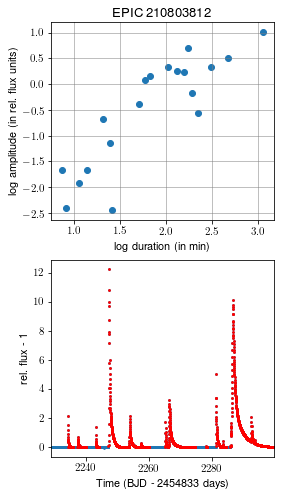

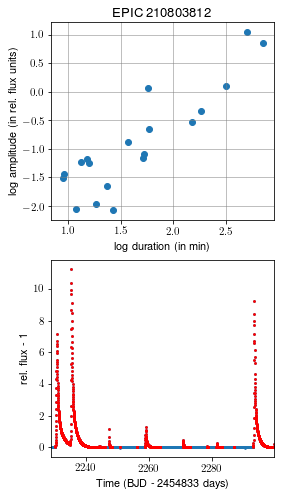

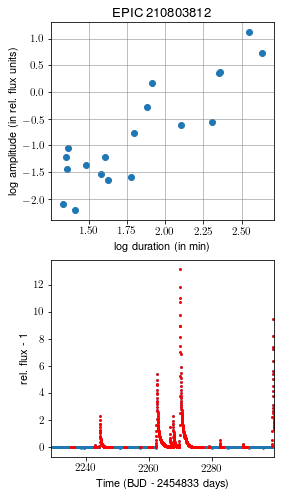

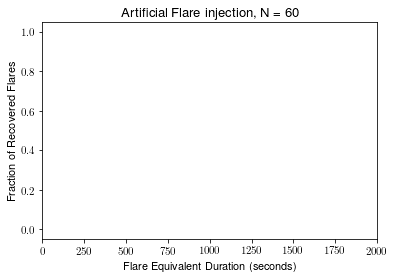

Writing to aprun/k2sc/210803812-c04_kepler_v2_lc.fits.
0 flare candidates found


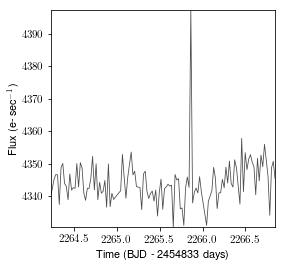

In [6]:
for i, oid in enumerate([210803812]):
    print('\nThis is the {}th light curve in the current pipeline.\n'.format(i))
    print(os.getcwd())
    print(oid)
    fakes = RunLC_cluster(oid, run=test, C=C, cluster=cluster,LCtype=LCtype)
    #fakes.to_csv("/home/eilin/research/k2_cluster_flares/aprun/k2sc_05/{}-c{}_kepler_v2_lc.fits_all_fakes.csv".format(oid,C))
#     for item in ['flares','flux']:
#         os.rename("{}_{}.csv".format(oid,item),
#                   "stars_shortlist/{}/results/{}/{}_{}.csv".format(cluster,test,oid,item))

#os.rename('flarelist.txt',
 #         'stars_shortlist/{0}/results/{1}/results/{0}_{1}_flarelist.txt'.format(cluster,test))

In [ ]:
flarelist = pd.read_csv('stars_shortlist/{0}/results/{1}/results/{0}_{1}_flarelist.txt'.format(cluster,test),
                       delimiter='\t')
flarelist = flarelist.rename(index=str, columns={'Object ID ':'EPIC',' Number of Flares ':'n_appa_flares'})
params2 = params.merge(flarelist, on='EPIC', how='left')
params2 = params2.drop(params2.columns[params2.columns.str.contains('Unnamed')],axis=1)

In [ ]:
params

In [ ]:
params2.to_csv(ploc)

## Fake flare statistics


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc, rcParams
rcParams.update({'font.size':12})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

def falsepos(fakes, ID, save=False):
    false = fakes[fakes.rec_fake!=0.].sort_values(by='istart_rec')
    false['ed_ratio']=false.ed_rec/false.ed_fake
    false = false.sort_values(by='ed_ratio')
    #print(false[false.ed_ratio>1].shape[0]/false.shape[0])
    falsepos = false[false.ed_ratio>1.]


    f, (ax1, ax2) = plt.subplots(2, sharex=True,figsize=(6,6))

    ax1.hist(fakes.ed_fake, bins=(1,10,100,1000,10000,100000,1000000),
             histtype='step',linewidth=2,color='k',label='injected')
    
    ax1.hist(fakes.ed_rec, bins=(1,10,100,1000,10000,100000,1000000),
             histtype='step',linewidth=2,color='k',label='recovered',linestyle='dashed')

    ax1.set_title('EPIC {}'.format(ID))
    ax1.set_ylabel('\# flares')
    ax1.legend()
    ax2.scatter(falsepos.ed_rec,falsepos.ed_ratio, 
                s=falsepos.ed_rec_err/falsepos.ed_rec*1e3,
                color='k',alpha=0.75)
    ax2.axhline(y=1.,color='r')
    ax2.axhline(y=1.1,color='r',linestyle='dashed')
    plt.xscale('log')
    ax2.set_yscale('log')

    plt.xlabel('recovered ED in s')
    ax2.set_ylabel('recovered fraction\n of injected ED')


    #ax3.set_ylabel('\# recovered flares')


    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    if save == True:
        plt.savefig('/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/corrected/false_positives_{}.jpg'.format(LCtype),dpi=300)
    return

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc, rcParams
rcParams.update({'font.size':12})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

def ratio(fakes, ID, save=False):
    f = fakes[fakes.rec_fake!=0.].sort_values(by='istart_rec')
    f['ed_ratio']=f.ed_rec/f.ed_fake
    f = f.sort_values(by='ed_ratio')
    f = f[f.ed_ratio<1.5]
    f = f[f.ed_rec>1]


    plt.figure(figsize=(7,5))

    plt.scatter(f.ed_rec,f.ed_ratio,s=f.ed_rec_err/f.ed_rec*1e3, alpha=0.5,color='k',
                label='$\sigma_{ED}/ED$')
    plt.axhline(y=1.,color='r')
    plt.axhline(y=1.1,color='r',linestyle='dashed')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim((0.1,1.5))
    plt.xlim((10,1e7))
    plt.xlabel('recovered ED in s')
    plt.ylabel('recovered fraction of injected ED')
    plt.title('EPIC {}'.format(ID))
    plt.legend(loc=4, frameon=False)
    if save == True:
        plt.savefig('/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/corrected/ed_ratio_{}.jpg'.format(ID),dpi=300)
    return 

In [ ]:
def fprate(fakes, LCtype, save=False):
    false = fakes[fakes.rec_fake!=0.].sort_values(by='istart_rec')
    false['ed_ratio']=false.ed_rec/false.ed_fake
    false.ed_ratio = false.ed_ratio.astype('float')
    false = false.sort_values(by='ed_ratio')
    overall_false_pos = false[false.ed_ratio>1.].shape[0]/false.shape[0]
    #false = false[false.ed_ratio>1.]

    bins = np.power(10,np.arange(0,7,0.05))
    false['range1'], bins = pd.cut(false.ed_rec, bins, retbins=True,include_lowest=True)
    m = pd.DataFrame()
    m['mean_fp_rate'] = false.groupby('range1').ed_ratio.apply(lambda x: x[x > 1.].shape[0])/false.groupby('range1').ed_ratio.size()
    m['summe'] = false.groupby('range1').ed_ratio.size()
    plt.figure(figsize=(7,5))
    m['binmids'] = (bins[1:]+bins[:-1])/2.
    m = m.dropna(how='any')
    plt.plot(m.binmids,m.mean_fp_rate)
    plt.xscale('log')
    plt.xlabel('recovered ED in s')
    plt.ylabel('false positive rate')
    if save == True:
        plt.savefig('/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/corrected/false_positives_ratio_{}.jpg'.format(LCtype),dpi=300)
    return

In [ ]:
def ratio_mean(fakes, LCtype, oid, save=False,plot=False):
    f = fakes[fakes.rec_fake!=0.].sort_values(by='istart_rec')
    f['ed_ratio']=f.ed_rec/f.ed_fake
    f = f.sort_values(by='ed_ratio')
    f = f[f.ed_ratio<1.5]
    f = f[f.ed_rec>1]

    bins = np.power(10,np.arange(1,8,0.05))
    f['range1'], bins = pd.cut(f.ed_rec, bins, retbins=True,include_lowest=True)
    m = pd.DataFrame()
    m['mean_ED_corr'] = f.groupby('range1').ed_ratio.mean()
    m['std_ED_corr'] = f.groupby('range1').ed_ratio.std()
    m['binmids'] = (bins[1:]+bins[:-1])/2.
    m = m.dropna(how='any')
    if plot==True:
        plt.errorbar(m.binmids,m.mean_ED_corr,yerr=m.std_ED_corr)
        plt.xscale('log')
        plt.xlabel('recovered ED in s')
        plt.ylabel('mean fraction of injected energy')
    if save == True:
        plt.savefig('/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/corrected/energy_underestimate_{}.jpg'.format(LCtype),dpi=300)
    return [m.binmids[m.mean_ED_corr>0.5].min(), m.binmids[m.mean_ED_corr>0.75].min(), m.binmids[m.mean_ED_corr>0.95].min()]


In [ ]:
from fakescorr import fakedf, fakescorr
LCtype = 'k2sc'
test = 'run_05'
#oid = 211005924
C = '05'
save=False
cluster = 'M44'
specs = pd.read_csv('stars_shortlist/{0}/{0}_parameter.csv'.format(cluster))
oid_list = specs.EPIC.tolist()
oid = oid_list[9]
fakes = pd.read_csv('/home/eilin/research/k2_cluster_flares/aprun/k2sc_05/{}-c{}_kepler_v2_lc.fits_all_fakes.csv'.format(oid,C))
# falsepos(fakes, oid, save=save)
# fprate(fakes, LCtype, save=save)
# ratio(fakes, oid, save=save)
flux, flares = import_flares(cluster, test, oid)
# fakescorr(flares, oid, C, cluster, test, LCtype)
# flares
m = fakedf(oid,C,cluster,test,LCtype,mode='numcorr')
print(m)
flares = fakescorr(flares, oid, C, cluster, test, LCtype)
flares.myed/flares.ED_true

In [ ]:
L, Ethres, ID, T, rat = [], [], [], [], []
cluster='M44'
specs = pd.read_csv('/work1/eilin/appaloosa/appaloosa/stars_shortlist/{0}/{0}_parameter.csv'.format(cluster))
oid_list = specs.EPIC.tolist()
#oid_list.remove(211073598)
for oid in oid_list:
    tL = specs.L_quiet[specs.EPIC==oid].values[0]
    L.append(tL)
    m = fakedf(oid,C,cluster,test,LCtype,mode='numcorr')
    fakes = pd.read_csv('/home/eilin/research/k2_cluster_flares/aprun/k2sc_05/{}-c{}_kepler_v2_lc.fits_all_fakes.csv'.format(oid,C))
    trat = ratio_mean(fakes, LCtype, oid)
    rat.append(np.asarray(trat)*tL)
    EDthres = np.asarray([m.mean_ed_fake[m.mean_rec_fake >= key/100].min() for key in trat])

    Ethres.append(EDthres*tL)
    ID.append(oid)
    T.append(specs['T'][specs.EPIC==oid].values[0])
#t = pd.DataFrame({'EPIC':ID,'L':L,'Ethres':Ethres,'Teff':T}).dropna(how='any')



E = np.asarray(Ethres).T
ethres50, ethres75, ethres95, = E[0], E[1], E[2]

In [ ]:
R = np.asarray(rat).T
rat50, rat75, rat95, = R[0], R[1], R[2]


In [ ]:
tall = pd.DataFrame({'EPIC':ID,
                  'L':L,
                  'ethres50':ethres50,
                  'ethres75':ethres75,
                  'ethres95':ethres95,
                  'rat50':rat50,
                  'rat75':rat75,
                  'rat95':rat95,
                  'T_eff':T,})
                  #'rat':rat})
ethres50[:5],ethres75[:5]

In [ ]:
tall.to_csv('/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/thresholds/{}_fakechar.csv'.format(cluster))

In [ ]:
cluster = 'M67'
C='05'
test='06'

In [ ]:
tall = pd.read_csv('/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/thresholds/{}_fakechar.csv'.format(cluster))

In [ ]:
print(tall.shape)
#tall = tall.dropna(how='any',subset=['ethres50'])
print(tall.shape)

In [ ]:
%matplotlib inline

from matplotlib import rc
rc('text',usetex=True)
rc('font',size=13)
rc('legend',fontsize=13)
#rc('text.latex',preamble=r'\usepackage{cmbright}')
#plt.figure()
p = ['50','75','95']
for perc in p:
    fig, ax = plt.subplots(figsize=(7,5))
    t=tall[['L','ethres{}'.format(perc),'rat{}'.format(perc),'T_eff']].dropna(how='any')
    ax.scatter(t['rat{}'.format(perc)],t['ethres{}'.format(perc)],#,kind='scatter',
          # ylim=(0,1e36),xlim=(5,250000),
           c=t['T_eff'],
           cmap='gist_rainbow',
    #       figsize=(16,10),
           alpha=0.75,
           s=15,
       #    loglog=True,
      #     xlabel='50\% energy recovery ratio',
              )
    #cax = plt.axes([0.85, 0.1, 0.075, 0.8])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'{}\% energy ratio threshold (erg)'.format(perc))
    ax.set_ylabel(r'{}\% recovery rate (erg)'.format(perc))
    l = np.linspace(1e31,1e34,100000)
    ax.plot(l,l)
    plt.ylim(5e29,1e36)
    plt.xlim(4e30,3e34)
    plt.savefig('stars_shortlist/share/thresholds/{}_{}_{}.png'.format(cluster,test,perc),dpi=300)


In [ ]:

rc('text',usetex=True)
rc('font',size=13)
rc('legend',fontsize=13)
for perc in p:
    fig, ax = plt.subplots(figsize=(7,5))
    t=tall[['L','ethres{}'.format(perc),'rat{}'.format(perc),'T_eff']].dropna(how='any')
    ax.scatter(t['L'],t['ethres{}'.format(perc)],#,kind='scatter',
          # ylim=(0,1e36),xlim=(5,250000),
           c=t['T_eff'],
           cmap='gist_rainbow',
    #       figsize=(16,10),
           alpha=0.75,
           s=15,
       #    loglog=True,
      #     xlabel='50\% energy recovery ratio',
              )
    #cax = plt.axes([0.85, 0.1, 0.075, 0.8])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'L (erg)')
    ax.set_ylabel(r'{}\% recovery rate (erg)'.format(perc))
    l = np.linspace(1e29,1e33,100000)
    ax.plot(l,l)
    plt.ylim(1e29,1e36)
    plt.xlim(4e28,1e33)
    plt.savefig('stars_shortlist/share/thresholds/{}_{}_{}_L.png'.format(cluster,test,perc),dpi=300)


In [ ]:
for perc in p:
    fig, ax = plt.subplots(figsize=(7,5))
    t=tall[['L','ethres{}'.format(perc),'rat{}'.format(perc),'T_eff']].dropna(how='any')
    ax.scatter(t['L'],t['rat{}'.format(perc)],#,kind='scatter',
          # ylim=(0,1e36),xlim=(5,250000),
           c=t['T_eff'],
           cmap='gist_rainbow',
    #       figsize=(16,10),
           alpha=0.75,
           s=15,
       #    loglog=True,
      #     xlabel='50\% energy recovery ratio',
              )
    #cax = plt.axes([0.85, 0.1, 0.075, 0.8])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('L (erg)'.format(perc))
    ax.set_ylabel(r'{}\% energy ratio threshold (erg)'.format(perc))
    l = np.linspace(1e29,1e33,100000)
    ax.plot(l,l)
    plt.ylim(1e29,1e35)
    plt.xlim(4e28,1e33)
    plt.savefig('stars_shortlist/share/thresholds/{}_{}_{}_L_ratio.png'.format(cluster,test,perc),dpi=300)


In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
t=tall[['L','ethres75','rat50','T_eff']].dropna(how='any')
ax.scatter(t['rat50'],t['ethres75'],#,kind='scatter',
      # ylim=(0,1e36),xlim=(5,250000),
       c=t['T_eff'],
       cmap='gist_rainbow',
#       figsize=(16,10),
       alpha=0.75,
       s=15,
   #    loglog=True,
  #     xlabel='50\% energy recovery ratio',
          )
#cax = plt.axes([0.85, 0.1, 0.075, 0.8])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'75\% energy ratio threshold in erg')
ax.set_ylabel(r'50\% recovery rate in erg')
l = np.linspace(1e31,1e34,100000)
ax.plot(l,l)
plt.ylim(5e29,1e36)
plt.xlim(4e30,3e34)
plt.savefig('stars_shortlist/share/thresholds/{}_{}_7550.png'.format(cluster,test,perc),dpi=300)


In [ ]:


cluster = 'Pleiades'
flux,flares = import_flares(cluster, test, oid)
flares.columns.values

In [ ]:
fakes = fakes[(fakes.rec_fake != 0.) &  (fakes.ed_rec/fakes.ed_fake > 100)].sort_values(by='istart_rec')
fakes.head()

In [ ]:
start = 0
f = fakes.iloc[start:]#start+40]

for i, row in f.iterrows():
    b,e = int(row.istart_rec), int(row.istop_rec)
    plt.plot(flux.time.iloc[b:e],
             flux.flux_gap.iloc[b:e]+float(i)+100.,
             color='r',linewidth=3)
plt.plot(flux.time.iloc[int(f.istart_rec.iloc[0]):e],
         flux.flux_gap.iloc[int(f.istart_rec.iloc[0]):e],
         color='k',linewidth=.3)

In [ ]:
a = np.array( [item for i, row in fakes.iterrows() 
                       for item in np.arange(row.istart_rec, row.istop_rec,1) ])
plt.hist(a,bins=int(max(a))//100)

In [ ]:
fakes.iloc[start:start+20]